#### Build model

In [1]:
%%writefile homerisk_model.py
import pandas as pd
import numpy as np

# modeling
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


MODEL_COLS = [
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
]
TARGET_COL = 'TARGET'


class RiskModel:
    
    
    def __init__(self, 
                 train, 
                 test, 
                 val=pd.DataFrame([]), 
                 params={}, 
                 type='RF', 
                 rounds=0,
                 cols=MODEL_COLS,
                 target=TARGET_COL,
        ):
        ''' Initialize but do nothing
        '''
        self.train = train.copy()
        self.test = test.copy()
        self.val = val.copy()
        self.feature_lookup = {}
        self.feature_lookup_rev = {}
        self.params = params
        self.model = None
        self.type = type
        self.preds = None
        self.rounds = rounds
        self.cols = cols
        self.target = target
    
    
    def build_lookups(self):
        ''' Build encoding lookups
        '''
        val_lookup = {}
        val_lookup_rev = {}
        for i, c in self.train.iteritems():

            if is_string_dtype(c):
                u = np.unique(c.astype('str'))
                kv = { v:i for i, v in zip(np.arange(u.shape[0]),u) }
                vk = { i:v for i, v in zip(np.arange(u.shape[0]),u) }
                val_lookup[i] = kv
                val_lookup_rev[i] = vk
        
        self.feature_lookup = val_lookup
        self.feature_lookup_rev = val_lookup_rev
    
    
    @staticmethod
    def find_encoding(x, lookup):
        
        if x in lookup:
            
            return lookup[x]
        
        else:
            
            return np.nan
    
    
    @staticmethod
    def ohe_cols(ohe, str_columns):
        ohecols = []
        m = ohe.feature_indices_[-1]
        for i, ind in enumerate(ohe.feature_indices_[:-1]):
            col = list(str_columns)[i]
            next_ind = ohe.feature_indices_[i+1]
            newcols = [ col+'_'+str(z) for z in range(next_ind - ind) ]
            ohecols += newcols

        return ohecols
    
    
    def run_encodings(self, ohe=True, minmax=False):
        ''' Encode values in training data
        '''
        strings = []
        for i, c in self.train.iteritems():
            
            if is_string_dtype(c):

                strings.append(i)
                self.train[i] = self.train[i].fillna('nan').apply(lambda x: self.find_encoding(x, self.feature_lookup[i]))
                self.test[i] = self.test[i].fillna('nan').apply(lambda x: self.find_encoding(x, self.feature_lookup[i]))
                
                if self.val.shape[0] > 0:
                    
                    self.val[i] = self.val[i].fillna('nan').apply(lambda x: self.find_encoding(x, self.feature_lookup[i]))
        
        if ohe:
            # create one hot encoder & transform data into OHE matrices
            oh = OneHotEncoder( handle_unknown='ignore', sparse=False )
            train_ohe = oh.fit_transform(self.train.loc[:, strings])
            test_ohe = oh.transform(self.test.loc[:, strings])
            
            if self.val.shape[0] >0:
                val_ohe = oh.transform(self.val.loc[:, strings])
            
            # create names for new OHE matrix columns
            strcols = self.train[strings].columns
            ohecols = self.ohe_cols(oh, strcols)
            
            # add new OHE datasets into dataframes
            train_ohe = pd.DataFrame(train_ohe, columns=[ohecols], index=self.train.index)
            test_ohe = pd.DataFrame(test_ohe, columns=[ohecols], index=self.test.index)
            self.train = pd.concat((self.train, train_ohe), axis=1)
            self.test = pd.concat((self.test, test_ohe), axis=1)
            
            if self.val.shape[0]:
                val_ohe = pd.DataFrame(val_ohe, columns=[ohecols], index=self.val.index)
                self.val = pd.concat((self.val, val_ohe), axis=1)
            
            # exclude original columns
            newcols = list(set(self.cols + ohecols))
            self.cols = [ c for c in newcols if c not in strcols ]
        
        if minmax:
            mm = MinMaxScaler(feature_range=(0, 1))
            self.train[ self.cols ] = mm.fit_transform(self.train[ self.cols ].fillna(0))
            self.test[ self.cols ] = mm.transform(self.test[ self.cols ].fillna(0))
            
            if self.val.shape[0] > 0:
                self.val[ self.cols ] = mm.transform(self.val[ self.cols ].fillna(0))
                            
    
    def train_model(self):
        ''' Train a randomforest model 
        '''
        if self.type == 'RF':
            
            m = RandomForestClassifier(**self.params)
            m.fit( self.train[ self.cols].fillna(0), self.train[self.target].values )
            self.model = m 
        
        if self.type == 'LR':
            
            lr = LogisticRegression(**self.params)
            lr.fit( self.train[ self.cols].fillna(0), self.train[self.target].values ) 
            self.model = lr
        
        if self.type == 'XGB':
            
            dtrain = xgb.DMatrix(self.train[ self.cols], label=self.train[self.target])
            
            if self.val.shape[0] > 0:
                
                dval = xgb.DMatrix(self.val[ self.cols], label=self.val[self.target])
                evallist  = [(dtrain,'train'), (dval,'eval')]
                gbdt = xgb.train(
                    self.params,
                    dtrain,
                    self.rounds,
                    evallist,
                    early_stopping_rounds = self.rounds // 10 ,
                    verbose_eval = self.rounds // 10 ,
                )
                self.model = gbdt
                
            else:
                
                gbdt = xgb.train(
                    self.params,
                    dtrain,
                    self.rounds,
                )
                self.model = gbdt
    
    
    def output_predictions(self):
        ''' 
        '''
        if self.type == 'RF' or self.type == 'LR':
            
            preds = self.model.predict_proba(self.test[ self.cols].fillna(0))[:, 1]
            return preds
        
        
        if self.type == 'XGB':
            
            dtest = xgb.DMatrix(self.test[ self.cols])
            preds = self.model.predict( dtest )
            return preds
    
    
    def save_predictions(self):
        ''' Dont output, just save (for validation)
        '''
        if self.type == 'RF' or self.type == 'LR':
            
            preds = self.model.predict_proba(self.test[ self.cols].fillna(0))[:, 1]
            self.test_preds = preds
            
            if self.val.shape[0] > 0:
                
                preds = self.model.predict_proba(self.val[ self.cols].fillna(0))[:, 1]
                self.val_preds = preds
                
        
        if self.type == 'XGB':
            
            dtest = xgb.DMatrix(self.test[ self.cols])
            preds = self.model.predict( dtest )
            self.test_preds = preds
            
            if self.val.shape[0] > 0:
                
                dval = xgb.DMatrix(self.val[ self.cols])
                preds = self.model.predict( dval )
                self.val_preds = preds
    
    
    def run(self):
        self.build_lookups()
        self.run_encodings(ohe=True, minmax=False)
        self.train_model()
        self.save_predictions()
        
        # create final output df 
        preds_df = pd.DataFrame(self.test_preds, columns=['TARGET'])
        preds_df['SK_ID_CURR'] = self.test.SK_ID_CURR
        self.preds_df = preds_df


Overwriting homerisk_model.py


In [2]:
from homerisk_model import *

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, log_loss

train = pd.read_csv('./application_train.csv.zip')
test = pd.read_csv('./application_test.csv.zip')

rf_params={
    'n_estimators':2000,
    'min_samples_split':4,
    'n_jobs': 4,
}
xgb_params ={
    'silent': 1 ,
    'booster': 'gbtree' ,
    'objective': 'binary:logistic' ,
    'eval_metric': 'logloss' ,
    'nthread': 16 ,
}

# prepare to show results
results = []
Xtrue = train[TARGET_COL].values


xgb_params['seed'] =             22
xgb_params['max_depth'] =        6
xgb_params['min_child_weight'] = 2
xgb_params['eta'] =              0.03
xgb_params['gamma'] =            0.0
xgb_params['colsample_bytree'] = 0.85
xgb_params['subsample'] =        0.85
xgb_params['alpha'] =            0.0
xgb_params['lambda'] =           0.0

K = 4
kf = KFold(n_splits=K)
xgval = np.zeros(train.shape[0])
rfval = np.zeros(train.shape[0])
lrval = np.zeros(train.shape[0])
xgtst = np.zeros(test.shape[0])
rftst = np.zeros(test.shape[0])
lrtst = np.zeros(test.shape[0])

for train_index, test_index in kf.split(train):
    # XGB
    xb = RiskModel( 
        train = train.iloc[train_index,:], 
        test = test, 
        val = train.iloc[test_index], 
        params = xgb_params, 
        type = 'XGB', 
        rounds = 800 )
    xb.run()
    xgval[test_index] = xb.val_preds
    xgtst += xb.test_preds / K
    
    # RF 
    rf = RiskModel( 
        train = train.iloc[train_index,:], 
        test = test, 
        val = train.iloc[test_index], 
        params=rf_params, 
        type='RF' 
    )
    rf.run()
    rfval[test_index] = rf.val_preds
    rftst += rf.test_preds / K
    
    # LR
    lr = RiskModel( 
        train = train.iloc[train_index,:], 
        test = test, 
        val = train.iloc[test_index], 
        params={'C':0.01}, 
        type='LR' 
    )
    lr.run()
    lrval[test_index] = lr.val_preds
    lrtst += lr.test_preds / K

# pd.DataFrame(results, columns=['Model','ROC','LogLoss','Depth','MCW'])

[0]	train-logloss:0.671835	eval-logloss:0.671852
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 80 rounds.
[80]	train-logloss:0.260756	eval-logloss:0.262992
[160]	train-logloss:0.241773	eval-logloss:0.248058
[240]	train-logloss:0.235482	eval-logloss:0.245852
[320]	train-logloss:0.231566	eval-logloss:0.245103
[400]	train-logloss:0.228275	eval-logloss:0.244766
[480]	train-logloss:0.225489	eval-logloss:0.244523
[560]	train-logloss:0.222752	eval-logloss:0.244375
[640]	train-logloss:0.220213	eval-logloss:0.244255
[720]	train-logloss:0.218032	eval-logloss:0.244209
[799]	train-logloss:0.21591	eval-logloss:0.244203
[0]	train-logloss:0.671755	eval-logloss:0.671933
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 80 rounds.
[80]	train-logloss:0.258931	eval-logloss:0.267415
[160]	train-logloss:0.240185	eval-logloss:0.25

#### Stack models

In [4]:
train['xgbval'] = xgval 
train['rfval'] = rfval
train['lrval'] = lrval
test['xgbval'] = xgtst
test['rfval'] = rftst
test['lrval'] = lrtst


results = []
Xtrue = train[TARGET_COL].values
kf = KFold(n_splits=K)
stackpreds = np.zeros(train.shape[0])
stackpreds_tst = np.zeros(test.shape[0])


models = [('xg',xgval), ('rf',rfval), ('lr',lrval)]
for m, Xpred in models:
    roc = roc_auc_score(Xtrue, Xpred)
    ll = log_loss(Xtrue, Xpred)
    results.append((m, roc, ll))


stack_params ={
    'silent': 1 ,
    'booster': 'gbtree' ,
    'objective': 'binary:logistic' ,
    'eval_metric': 'logloss' ,
    'nthread': 16 ,
}
stack_params['seed'] =             22
stack_params['max_depth'] =        4
stack_params['min_child_weight'] = 1
stack_params['eta'] =              0.03
stack_params['gamma'] =            0.0
stack_params['colsample_bytree'] = 0.8
stack_params['subsample'] =        0.8
stack_params['alpha'] =            0.0
stack_params['lambda'] =           0.0
stack_cols = MODEL_COLS + ['xgbval','rfval']


for train_index, test_index in kf.split(train):
    
    
    mstack = RiskModel( 
        train = train.iloc[train_index], 
        test = test,
        val = train.iloc[test_index],
        params = stack_params, 
        type = 'XGB', 
        rounds = 150 ,
        cols = stack_cols ,
    )
    mstack.run()
    stackpreds[test_index] = mstack.val_preds
    stackpreds_tst += mstack.test_preds / K


roc = roc_auc_score(Xtrue, stackpreds)
ll = log_loss(Xtrue, stackpreds)
results.append(('stack', roc, ll))

[0]	train-logloss:0.671607	eval-logloss:0.671607
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 15 rounds.
[15]	train-logloss:0.458787	eval-logloss:0.458684
[30]	train-logloss:0.356084	eval-logloss:0.35579
[45]	train-logloss:0.303114	eval-logloss:0.302656
[60]	train-logloss:0.274875	eval-logloss:0.274291
[75]	train-logloss:0.260161	eval-logloss:0.259529
[90]	train-logloss:0.252587	eval-logloss:0.251973
[105]	train-logloss:0.248613	eval-logloss:0.248085
[120]	train-logloss:0.246516	eval-logloss:0.246131
[135]	train-logloss:0.245455	eval-logloss:0.245251
[149]	train-logloss:0.244849	eval-logloss:0.244821
[0]	train-logloss:0.671538	eval-logloss:0.671647
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 15 rounds.
[15]	train-logloss:0.457958	eval-logloss:0.459476
[30]	train-logloss:0.354842	eval-logloss:0.35746
[4

In [5]:
pd.DataFrame(results, columns=['Model','ROC','LogLoss'])

,Model,ROC,LogLoss
0,xg,0.759818,0.245556
1,rf,0.724322,0.256339
2,lr,0.621593,0.275463
3,stack,0.758902,0.246194


#### Prepare output

In [6]:
# create final output df 
preds_df = pd.DataFrame(stackpreds_tst, columns=['TARGET'])
preds_df['SK_ID_CURR'] = test.SK_ID_CURR

#### Analyze predictions

In [7]:
import seaborn as sns
%matplotlib inline

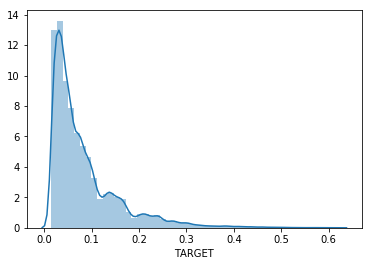

In [8]:
sns.distplot(preds_df.TARGET)

In [9]:
preds_df[['SK_ID_CURR','TARGET']].to_csv('submission.csv', sep=',', header=True, index=False)

In [10]:
!gzip -f submission.csv
!kaggle competitions submit -c home-credit-default-risk -f submission.csv.gz -m "kfold"

Successfully submitted to Home Credit Default Risk